In [ ]:
# !fusermount -u /content/drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

train = pd.read_csv('/content/drive/MyDrive/github_folder/house_price_prediction_only_spatial_data/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/github_folder/house_price_prediction_only_spatial_data/test_data.csv')

In [3]:
X_train = train.drop(['id', 'price'], axis = 1)
y_train = train['price']
target = np.array(train['price'])
total_data = train

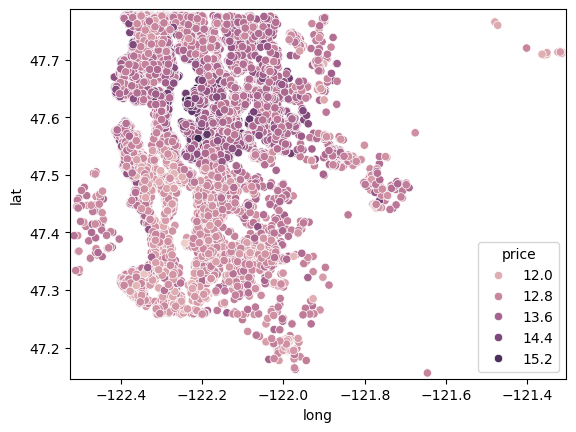

In [4]:
latitude = X_train['lat']
longtitude = X_train['long']
lim_x = (min(longtitude)-0.01, max(longtitude)+0.01)
lim_y = (min(latitude)-0.01, max(latitude)+0.01)
target = np.log(y_train)

fig, ax = plt.subplots()
sns.scatterplot(x = longtitude, y = latitude,
                hue = target)
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.show()

In [5]:
class Calculator:
    def __init__(self, option, target):
        self.target = target
        self.operations = {
            "mean": self.calculate_mean,
            "variance": self.calculate_variance,
            "median": self.calculate_median,
            "mode": self.calculate_mode
        }

        if option in self.operations:
            self.result = self.operations[option]
        else:
            raise ValueError(f"Invalid option: {option}")

    def calculate_mean(self):
        return np.mean(self.target)

    def calculate_variance(self):
        return np.var(self.target)

    def calculate_median(self):
        return np.median(self.target)

    def calculate_mode(self):
        mode_result = stats.mode(self.target)
        return mode_result.mode[0]

In [6]:
class SquareAreaExtractor:
    def __init__(self, x, y):
        self.lim_x = (min(x), max(x))
        self.lim_y = (min(y), max(y))

    def divide_space(self, num_interval):
        x_linspace = np.linspace(self.lim_x[0], self.lim_x[1], num_interval)
        y_linspace = np.linspace(self.lim_y[0], self.lim_y[1], num_interval)
        x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
        return x_grid, y_grid, num_interval

    def calculate_area(self, num_interval, x_area, y_area, targetdata, option):
        x_grid, y_grid, num_interval = self.divide_space(num_interval)
        indicator = np.zeros((num_interval-1, num_interval-1), dtype= np.int64)

        index_list = []
        area_list = []
        option_list = []

        for i in range(0, num_interval - 1):
            for j in range(0, num_interval - 1):
                x_lb, x_ub = x_grid[0][i], x_grid[0][i + 1]
                y_lb, y_ub = y_grid[j][0], y_grid[j + 1][0]

                condition1 = (x_area < x_ub) & (x_area >= x_lb)
                condition2 = (y_area < y_ub) & (y_area >= y_lb)
                condition = condition1 & condition2

                if sum(condition) >= (targetdata.shape[0] / (num_interval - 1)**2):
                    indicator[i][j] = int(1)
                    subdata = np.array(targetdata[condition])
                    res = Calculator(option, subdata).result()

                    index_tuple = ((i, i + 1), (j, j + 1))
                    area_tuple = ((x_lb, x_ub),(y_lb, y_ub))

                    index_list.append(index_tuple)
                    area_list.append(area_tuple)
                    option_list.append(res)

        return index_list, area_list, option_list

    def get_k_indices(self, num_interval, x_area, y_area, targetdata, option, k, descending = True):
        if descending:
            order = -1
        else: order = 1
        index_list, area_list, option_list = self.calculate_area(num_interval, x_area, y_area, targetdata, option)

        index_array, area_array, option_array = np.array(index_list), np.array(area_list), np.array(option_list)

        idxarr_updated = index_array[np.argsort(option_array)][::order][: k]
        areaarr_updated = area_array[np.argsort(option_array)][::order][: k]

        return idxarr_updated, areaarr_updated

In [7]:
def draw_rectangular(area_array, x_area, y_area, target):
    x = x_area
    y = y_area

    lim_x = (min(x) - 0.01, max(x) + 0.01)
    lim_y = (min(y) - 0.01, max(y) + 0.01)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(lim_x)
    ax.set_ylim(lim_y)
    ax = sns.scatterplot(x = x_area, y = y_area,
                hue = target)
    for area in area_array:
        x, y = area[0][0], area[1][0]
        width = area[0][1] - area[0][0]
        height = area[1][1] - area[1][0]

        rect = patches.Rectangle(
                (x, y),
                width, height,
                edgecolor = 'r',
                facecolor = 'none')

        ax.add_patch(rect)
    plt.show()

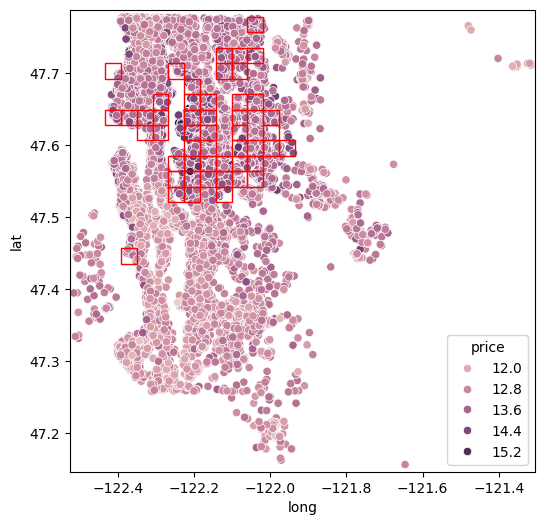

In [8]:
extractor = SquareAreaExtractor(longtitude, latitude)
idxarr, areaarr = extractor.get_k_indices(30,
                                          longtitude,
                                          latitude,
                                          target,
                                          option = 'mean',
                                          k = 50,
                                          descending = True)
draw_rectangular(areaarr, X_train['long'], X_train['lat'], target)

In [9]:
def LineProjecter(start, end, x, y, double_sided = False):
    d = np.array(end) - np.array(start)
    w = np.array([-d[1], d[0]])
    position_list = []
    projected_list = []
    if double_sided:
        for i in range(x.shape[0]):
            point = np.array([x[i], y[i]])
            dot_product = np.dot(w, point - np.array(start))

            if dot_product >= 0:
                position_list.append(1)
            else:
                position_list.append(0)

            proj = np.dot(d, point) / np.dot(d, d)
            projected_list.append(proj)
    else:
        for i in range(x.shape[0]):
            point = np.array([x[i], y[i]])
            proj = np.dot(d, point) / np.dot(d, d)
            projected_list.append(proj)
    return position_list, projected_list

In [10]:
def Start_End_Selector(option, x, y):
    if option == "random":
        randlong = np.random.uniform(min(x), max(x), 2)
        randlat = np.random.uniform(min(y), max(y), 2)
        start = (randlong[0], randlat[0])
        end = (randlong[1], randlat[1])
        return start, end
    elif option == "user":
        start = (float(input("start_long: ")), float(input("start_lat: ")))
        end = (float(input("end_long: ")), float(input("end_lat: ")))
        return start, end
    else:
        raise ValueError("Invalid option")

In [11]:
class LearningAlgorithm:
    def __init__(self, option):
        self.algorithm = {
            "randomforest": RandomForestRegressor(),
            "xgboost": XGBRegressor()
        }
        if option in self.algorithm:
            self.model = self.algorithm[option]
        else:
            raise ValueError(f"Invalid option: {option}")

    def fit(self, xt, yt):
        self.model.fit(xt, yt)

    def predict(self, xv):

        return self.model.predict(xv)

In [12]:
class LineProjectOptimizer:
    def __init__(self, projected_list, position_list, target):
        self.df = pd.DataFrame()
        self.df['projected'] = projected_list
        if position_list is not None:
            self.df['position'] = position_list
        self.target = target

    def split_dataset(self, rate):
        xt, xv, yt, yv = train_test_split(self.df, self.target, test_size = rate)
        return xt, xv, yt, yv

    def get_loss_of_line(self, rate, option):
        xt, xv, yt, yv = self.split_dataset(rate)
        clf = LearningAlgorithm(option)
        clf.fit(xt, yt)
        y_pred = clf.predict(xv)
        loss = np.sqrt(np.mean((yv - y_pred)**2))
        return loss

In [13]:
def get_k_lines(iteration,
                k,
                option_point,
                option_algorithm,
                spatial_info,
                target,
                splitrate = 0.2,
                double_sided = False):

    longtitude = np.array(spatial_info['long'])
    latitude = np.array(spatial_info['lat'])
    target = np.array(target)
    loss_list = []
    data_list = []
    info_list = []
    if double_sided:
        for i in range(iteration):
            print(f"{i + 1}-th iteration ({i + 1} / {iteration})")
            start, end = Start_End_Selector(option_point, longtitude, latitude)
            position_list, projected_list = LineProjecter(start, end, longtitude, latitude, True)
            optimizer = LineProjectOptimizer(projected_list, position_list, target)
            loss = optimizer.get_loss_of_line(splitrate, option_algorithm)
            loss_list.append(loss)
            data = pd.DataFrame()
            data["projected"] = projected_list
            data["position"] = position_list
            data_list.append(data)
            info_list.append((start, end))
    else:
        for i in range(iteration):
            print(f"{i + 1}-th iteration ({i + 1} / {iteration})")
            start, end = Start_End_Selector(option_point, longtitude, latitude)
            _, projected_list = LineProjecter(start, end, longtitude, latitude, True)
            optimizer = LineProjectOptimizer(projected_list, _, target)
            loss = optimizer.get_loss_of_line(splitrate, option_algorithm)
            loss_list.append(loss)
            data = pd.DataFrame()
            data["projected"] = projected_list
            data_list.append(data)
            info_list.append((start, end))


    idxarr = np.argsort(loss_list)[:k]
    lossarr = np.sort(loss_list)[:k]
    return idxarr, lossarr, data_list, info_list

In [14]:
spatial_info = X_train[['long', 'lat']]
target = np.log(y_train)
idxarr, lossarr, data_list, info_list = get_k_lines(100,
                                                    10,
                                                    "random",
                                                    "randomforest",
                                                    spatial_info,
                                                    target,
                                                    splitrate = 0.2,
                                                    double_sided = True)

1-th iteration (1 / 100)
2-th iteration (2 / 100)
3-th iteration (3 / 100)
4-th iteration (4 / 100)
5-th iteration (5 / 100)
6-th iteration (6 / 100)
7-th iteration (7 / 100)
8-th iteration (8 / 100)
9-th iteration (9 / 100)
10-th iteration (10 / 100)
11-th iteration (11 / 100)
12-th iteration (12 / 100)
13-th iteration (13 / 100)
14-th iteration (14 / 100)
15-th iteration (15 / 100)
16-th iteration (16 / 100)
17-th iteration (17 / 100)
18-th iteration (18 / 100)
19-th iteration (19 / 100)
20-th iteration (20 / 100)
21-th iteration (21 / 100)
22-th iteration (22 / 100)
23-th iteration (23 / 100)
24-th iteration (24 / 100)
25-th iteration (25 / 100)
26-th iteration (26 / 100)
27-th iteration (27 / 100)
28-th iteration (28 / 100)
29-th iteration (29 / 100)
30-th iteration (30 / 100)
31-th iteration (31 / 100)
32-th iteration (32 / 100)
33-th iteration (33 / 100)
34-th iteration (34 / 100)
35-th iteration (35 / 100)
36-th iteration (36 / 100)
37-th iteration (37 / 100)
38-th iteration (38

In [15]:
def draw_line(start, end, x_area, y_area, target):
    x = x_area
    y = y_area

    lim_x = (min(x) - 0.01, max(x) + 0.01)
    lim_y = (min(y) - 0.01, max(y) + 0.01)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(lim_x)
    ax.set_ylim(lim_y)
    ax = sns.scatterplot(x = x_area, y = y_area,
                hue = target)

    start_x, start_y = start
    end_x, end_y = end
    slope = (end_y - start_y) / (end_x - start_x)
    intercept = start_y - slope * start_x

    line_x = np.array(lim_x)
    line_y = slope * line_x + intercept

    ax.plot(line_x, line_y, color='r', linestyle='-', linewidth=1)

    plt.show()

In [16]:
data_list[1], info_list[1]

(        projected  position
 0     -155.466906         0
 1     -155.258223         1
 2     -155.740888         1
 3     -155.810328         1
 4     -155.809675         1
 ...           ...       ...
 12963 -155.784479         1
 12964 -155.524479         1
 12965 -155.705941         1
 12966 -155.718743         0
 12967 -155.476234         1
 
 [12968 rows x 2 columns],
 ((-122.37063102136551, 47.3907956674662),
  (-121.67637226216604, 47.53245637960834)))

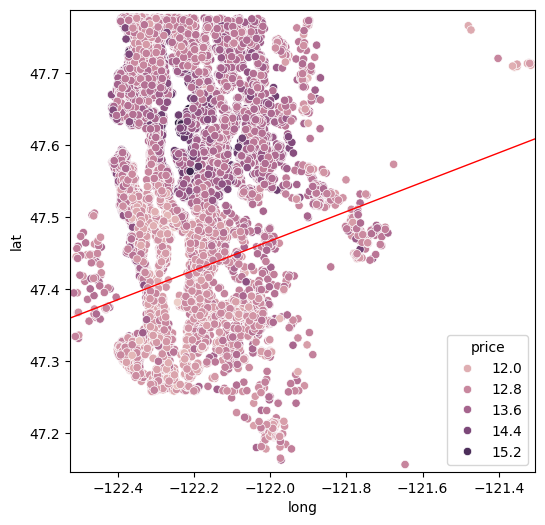

In [17]:
draw_line(info_list[1][0], info_list[1][1], X_train['long'], X_train['lat'], target)